In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive',force_remount=True)
os.chdir('/content/drive/My Drive/UNet_BTS')

Mounted at /content/drive


In [ ]:
import tensorflow as t
print(t.__version__)

2.4.1


In [ ]:
!pip install SimpleITK

In [ ]:
import SimpleITK as sitk 
from tqdm import tqdm
import numpy as np

from keras.utils import to_categorical,normalize
from keras.models import Model
from keras.layers import MaxPooling2D,concatenate,add,Conv2D,Dense,BatchNormalization,Concatenate,Input,Dropout,Maximum,Activation,Dense,Flatten,UpSampling2D,Conv2DTranspose,Add,Multiply,Lambda
from keras.optimizers import SGD,Adam,RMSprop
import keras.callbacks as callbacks
import keras.initializers as initializers
from keras.callbacks import Callback
from keras import regularizers
from keras import backend as K

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



In [ ]:
path = './HGG1/'

In [ ]:
def load_data(path):
  my_dir = sorted(os.listdir(path))
  data = []
  gt = []
  for p in tqdm(my_dir):
    data_list = sorted(os.listdir(path+p))
    img_itk = sitk.ReadImage(path + p + '/'+ data_list[0])
    flair = sitk.GetArrayFromImage(img_itk)
    img_itk = sitk.ReadImage(path + p + '/'+ data_list[1])
    seg =  sitk.GetArrayFromImage(img_itk)
    img_itk = sitk.ReadImage(path + p + '/'+ data_list[2])    
    t1 =  sitk.GetArrayFromImage(img_itk)
    img_itk = sitk.ReadImage(path + p + '/'+ data_list[3])
    t1ce =  sitk.GetArrayFromImage(img_itk)
    img_itk = sitk.ReadImage(path + p + '/'+ data_list[4])
    t2 =  sitk.GetArrayFromImage(img_itk)
    data.append([flair,t1,t1ce,t2])
    gt.append(seg)
  data = np.asarray(data,dtype=np.float32)
  gt = np.asarray(gt,dtype=np.uint8)
  return data,gt

In [ ]:
#HGG
data,gt = load_data(path) 

100%|██████████| 50/50 [00:22<00:00,  2.19it/s]


In [ ]:
data.shape, gt.shape, data.dtype, gt.dtype

((50, 4, 155, 240, 240), (50, 155, 240, 240), dtype('float32'), dtype('uint8'))

In [ ]:
data = np.transpose(data,(0,2,3,4,1))

In [ ]:
data = data[:,30:120,30:222,30:222,:].reshape([-1,192,192,4])   #taking 30-120 slices
gt = gt[:,30:120,30:222,30:222].reshape([-1,192,192,1])

In [ ]:
gt[np.where(gt==4)]=3

In [ ]:
data.shape, gt.shape, data.dtype, gt.dtype

((4500, 192, 192, 4), (4500, 192, 192, 1), dtype('float32'), dtype('uint8'))

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(data, gt, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25,random_state=42)

In [ ]:
X_train.shape,Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((2700, 192, 192, 4),
 (2700, 192, 192, 1),
 (900, 192, 192, 4),
 (900, 192, 192, 1),
 (900, 192, 192, 4),
 (900, 192, 192, 1))

In [ ]:
Y_train = to_categorical(Y_train)
Y_val = to_categorical(Y_val)
X_train = (X_train-np.mean(X_train))/np.max(X_train)
X_test = (X_test-np.mean(X_test))/np.max(X_test)
X_val = (X_val-np.mean(X_val))/np.max(X_val)

In [ ]:
def dice_coef(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection) / (K.sum(K.square(y_true),axis=-1) + K.sum(K.square(y_pred),axis=-1) + epsilon)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [ ]:
#encoder

inputs = Input(shape=(192,192,4),name='input')                                              

block0_conv1 = Conv2D(32, 3,padding='same',activation='relu',name='block0_conv1')(inputs)
block0_norm1 = BatchNormalization(name='block0_batch_norm1')(block0_conv1)
block0_conv2 = Conv2D(32, 3,padding='same',activation='relu',name='block0_conv2')(block0_norm1)
block0_norm2 = BatchNormalization(name='block0_batch_norm2')(block0_conv2)
block0_pool = MaxPooling2D(name='block0_pool')(block0_norm2)

block1_conv1 = Conv2D(64,3,padding='same',activation='relu',name='block1_conv1')(block0_pool)
block1_norm1 = BatchNormalization(name='block1_batch_norm1')(block1_conv1)
block1_conv2 = Conv2D(64,3,padding='same',activation='relu',name='block1_conv2')(block1_norm1)
block1_norm2 = BatchNormalization(name='block1_batch_norm2')(block1_conv2)
block1_pool = MaxPooling2D(name='block1_pool')(block1_norm2)

block2_conv1 = Conv2D(128,3,padding='same',activation='relu',name='block2_conv1')(block1_pool)
block2_norm1 = BatchNormalization(name='block2_batch_norm1')(block2_conv1)
block2_conv2 = Conv2D(128,3,padding='same',activation='relu',name='block2_conv2')(block2_norm1)
block2_norm2 = BatchNormalization(name='block2_batch_norm2')(block2_conv2)
block2_pool = MaxPooling2D(name='block2_pool')(block2_norm2)

encoder_dropout_1 = Dropout(0.2,name='encoder_dropout_1')(block2_pool)

block3_conv1 = Conv2D(256,3,padding='same',activation='relu',name='block3_conv1')(encoder_dropout_1)
block3_norm1 = BatchNormalization(name='block3_batch_norm1')(block3_conv1)
block3_conv2 = Conv2D(256,3,padding='same',activation='relu',name='block3_conv2')(block3_norm1)
block3_norm2 = BatchNormalization(name='block3_batch_norm2')(block3_conv2)
block3_pool = MaxPooling2D(name='block3_pool')(block3_norm2)

block4_conv1 = Conv2D(512,3,padding='same',activation='relu',name='block4_conv1')(block3_pool)
block4_norm1 = BatchNormalization(name='block4_batch_norm1')(block4_conv1)
block4_conv2 = Conv2D(512,3,padding='same',activation='relu',name='block4_conv2')(block4_norm1)
block4_norm2 = BatchNormalization(name='block4_batch_norm2')(block4_conv2)
block4_pool = MaxPooling2D(name='block4_pool')(block4_norm2)

block5_conv1 = Conv2D(1024,3,padding='same',activation='relu',name='block5_conv1')(block4_pool)

#decoder
up_pool1 = Conv2DTranspose(512,3,strides = (2, 2),padding='same',activation='relu',name='up_pool1')(block5_conv1)
merged_block1 = Add()([block4_norm1, block4_norm2, up_pool1])
decod_block1_conv1 = Conv2D(512,3, padding = 'same', activation='relu',name='decod_block1_conv1')(merged_block1)

up_pool2 = Conv2DTranspose(256,3,strides = (2, 2),padding='same',activation='relu',name='up_pool2')(decod_block1_conv1)
merged_block2 = Add()([block3_norm1, block3_norm2,up_pool2])
decod_block2_conv1 = Conv2D(256,3,padding = 'same',activation='relu',name='decod_block2_conv1')(merged_block2)

decoder_dropout_1 = Dropout(0.2,name='decoder_dropout_1')(decod_block2_conv1)

up_pool3 = Conv2DTranspose(128,3,strides = (2, 2),padding='same',activation='relu',name='up_pool3')(decoder_dropout_1)
merged_block3 = Add()([block2_norm1, block2_norm2 ,up_pool3])
decod_block3_conv1 = Conv2D(128,3,padding = 'same',activation='relu',name='decod_block3_conv1')(merged_block3)

up_pool4 = Conv2DTranspose(64,3,strides = (2, 2),padding='same',activation='relu',name='up_pool4')(decod_block3_conv1)
merged_block4 = Add()([block1_norm1, block1_norm1, up_pool4])
decod_block4_conv1 = Conv2D(64,3,padding = 'same',activation='relu',name='decod_block4_conv1')(merged_block4)

up_pool5 = Conv2DTranspose(32,3,strides = (2, 2),padding='same',activation='relu',name='up_pool5')(decod_block4_conv1)
merged_block5 = Add()([block0_norm1, block0_norm2 ,up_pool5])
decod_block5_conv1 = Conv2D(32,3,padding = 'same',activation='relu',name='decod_block5_conv1')(merged_block5)

#encoder
block6_conv1 = Conv2D(32, 3,padding='same',activation='relu',name='block6_conv1')(decod_block5_conv1)
block6_norm1 = BatchNormalization(name='block6_batch_norm1')(block6_conv1)
block6_conv2 = Conv2D(32, 3,padding='same',activation='relu',name='block6_conv2')(block6_norm1)
block6_norm2 = BatchNormalization(name='block6_batch_norm2')(block6_conv2)
block6_pool = MaxPooling2D(name='block6_pool')(block6_norm2)

block7_conv1 = Conv2D(64,3,padding='same',activation='relu',name='block7_conv1')(block6_pool)
block7_norm1 = BatchNormalization(name='block7_batch_norm1')(block7_conv1)
block7_conv2 = Conv2D(64,3,padding='same',activation='relu',name='block7_conv2')(block7_norm1)
block7_norm2 = BatchNormalization(name='block7_batch_norm2')(block7_conv2)
block7_pool = MaxPooling2D(name='block7_pool')(block7_norm2)

block8_conv1 = Conv2D(128,3,padding='same',activation='relu',name='block8_conv1')(block7_pool)
block8_norm1 = BatchNormalization(name='block8_batch_norm1')(block8_conv1)
block8_conv2 = Conv2D(128,3,padding='same',activation='relu',name='block8_conv2')(block8_norm1)
block8_norm2 = BatchNormalization(name='block8_batch_norm2')(block8_conv2)
block8_pool = MaxPooling2D(name='block8_pool')(block8_norm2)

encoder_dropout_2 = Dropout(0.2,name='encoder_dropout_2')(block8_pool)

block9_conv1 = Conv2D(256,3,padding='same',activation='relu',name='block9_conv1')(encoder_dropout_2)
block9_norm1 = BatchNormalization(name='block9_batch_norm1')(block9_conv1)
block9_conv2 = Conv2D(256,3,padding='same',activation='relu',name='block9_conv2')(block9_norm1)
block9_norm2 = BatchNormalization(name='block9_batch_norm2')(block9_conv2)
block9_pool = MaxPooling2D(name='block9_pool')(block9_norm2)

block10_conv1 = Conv2D(512,3,padding='same',activation='relu',name='block10_conv1')(block9_pool)
block10_norm1 = BatchNormalization(name='block10_batch_norm1')(block10_conv1)
block10_conv2 = Conv2D(512,3,padding='same',activation='relu',name='block10_conv2')(block10_norm1)
block10_norm2 = BatchNormalization(name='block10_batch_norm2')(block10_conv2)
block10_pool = MaxPooling2D(name='block10_pool')(block10_norm2)

block11_conv1 = Conv2D(1024,3,padding='same',activation='relu',name='block11_conv1')(block10_pool)

#decoder
up_pool6 = Conv2DTranspose(512,3,strides = (2, 2),padding='same',activation='relu',name='up_pool6')(block11_conv1)
merged_block6 = Add()([block10_norm1, block10_norm2, up_pool6])
decod_block6_conv1 = Conv2D(512,3, padding = 'same', activation='relu',name='decod_block6_conv1')(merged_block6)

up_pool7 = Conv2DTranspose(256,3,strides = (2, 2),padding='same',activation='relu',name='up_pool7')(decod_block6_conv1)
merged_block7 = Add()([block9_norm1, block9_norm2,up_pool7])
decod_block7_conv1 = Conv2D(256,3,padding = 'same',activation='relu',name='decod_block7_conv1')(merged_block7)

decoder_dropout_2 = Dropout(0.2,name='decoder_dropout_2')(decod_block7_conv1)

up_pool8 = Conv2DTranspose(128,3,strides = (2, 2),padding='same',activation='relu',name='up_pool8')(decoder_dropout_2)
merged_block8 = Add()([block8_norm1, block8_norm2 ,up_pool8])
decod_block8_conv1 = Conv2D(128,3,padding = 'same',activation='relu',name='decod_block8_conv1')(merged_block8)

up_pool9 = Conv2DTranspose(64,3,strides = (2, 2),padding='same',activation='relu',name='up_pool9')(decod_block8_conv1)
merged_block9 = Add()([block7_norm1, block7_norm1, up_pool9])
decod_block9_conv1 = Conv2D(64,3,padding = 'same',activation='relu',name='decod_block9_conv1')(merged_block9)

up_pool10 = Conv2DTranspose(32,3,strides = (2, 2),padding='same',activation='relu',name='up_pool10')(decod_block9_conv1)
merged_block10 = Add()([block6_norm1, block6_norm2 ,up_pool10])
decod_block10_conv1 = Conv2D(32,3,padding = 'same',activation='relu',name='decod_block10_conv1')(merged_block10)




pre_output = Conv2D(32,1,padding = 'same',activation='relu',name='pre_output')(decod_block10_conv1)

output = Conv2D(4,1,padding='same',activation='softmax',name='output')(pre_output)

model = Model(inputs = inputs, outputs = output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 192, 192, 4) 0                                            
__________________________________________________________________________________________________
block0_conv1 (Conv2D)           (None, 192, 192, 32) 1184        input[0][0]                      
__________________________________________________________________________________________________
block0_batch_norm1 (BatchNormal (None, 192, 192, 32) 128         block0_conv1[0][0]               
__________________________________________________________________________________________________
block0_conv2 (Conv2D)           (None, 192, 192, 32) 9248        block0_batch_norm1[0][0]         
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer=Adam(lr=1e-5),loss=dice_coef_loss,metrics=[dice_coef,'accuracy'])
model.save_weights('wnet-weights-n.hdf5')
checkpointer = callbacks.ModelCheckpoint(filepath = 'wnet-weights-n.hdf5',save_best_only=True)
training_log = callbacks.TensorBoard(log_dir='./Model_logs')

In [ ]:
history = model.fit(X_train,Y_train,validation_data=(X_val,Y_val),batch_size=8,epochs=30,callbacks=[training_log,checkpointer],shuffle=True)

Epoch 1/30
338/338 [==============================] - 118s 235ms/step - loss: 0.2889 - dice_coef: 0.7111 - accuracy: 0.8229 - val_loss: 0.0302 - val_dice_coef: 0.9698 - val_accuracy: 0.9704
Epoch 2/30
338/338 [==============================] - 76s 226ms/step - loss: 0.0284 - dice_coef: 0.9716 - accuracy: 0.9717 - val_loss: 0.0295 - val_dice_coef: 0.9705 - val_accuracy: 0.9705
Epoch 3/30
338/338 [==============================] - 76s 226ms/step - loss: 0.0289 - dice_coef: 0.9711 - accuracy: 0.9711 - val_loss: 0.0295 - val_dice_coef: 0.9705 - val_accuracy: 0.9705
Epoch 4/30
338/338 [==============================] - 77s 226ms/step - loss: 0.0299 - dice_coef: 0.9701 - accuracy: 0.9701 - val_loss: 0.0295 - val_dice_coef: 0.9705 - val_accuracy: 0.9705
Epoch 5/30
338/338 [==============================] - 77s 227ms/step - loss: 0.0302 - dice_coef: 0.9698 - accuracy: 0.9698 - val_loss: 0.0295 - val_dice_coef: 0.9705 - val_accuracy: 0.9705
Epoch 6/30
338/338 [==============================] - 

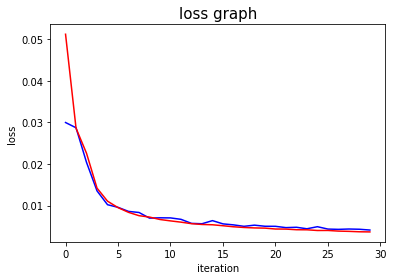

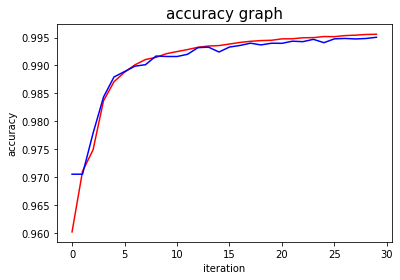

In [ ]:
a = history.history

list_traindice = a['accuracy']
list_testdice = a['val_accuracy']

list_trainloss = a['loss']
list_testloss = a['val_loss']

plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()



In [ ]:
Y_pre = np.argmax(model.predict(X_test),axis=-1)

In [ ]:
np.unique(Y_pre)

array([0, 1, 2, 3])

In [ ]:
Y_pre=Y_pre.reshape(-1,192,192,1)

In [ ]:
Y_test.shape,X_test.shape

((900, 192, 192, 1), (900, 192, 192, 4))

X_test 0


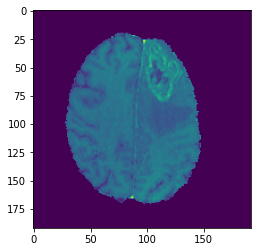

Predicted 0


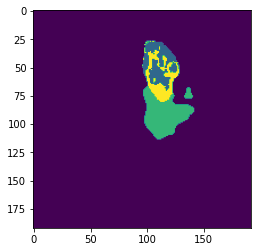

Actual 0


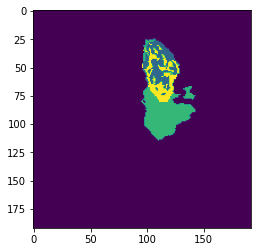

X_test 1


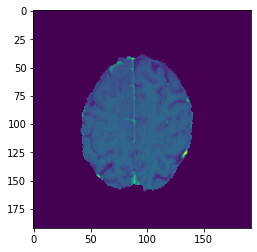

Predicted 1


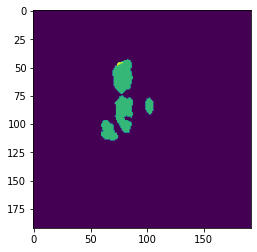

Actual 1


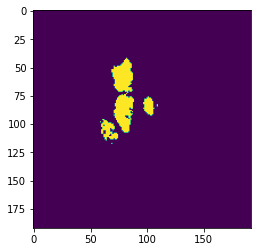

X_test 2


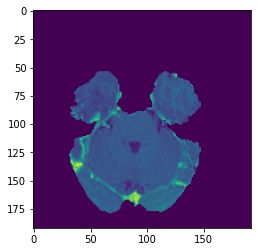

Predicted 2


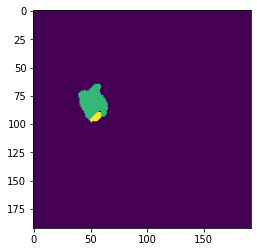

Actual 2


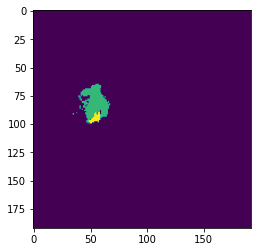

X_test 3


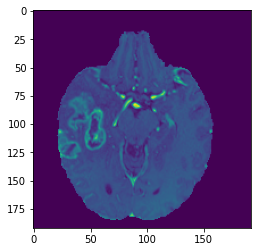

Predicted 3


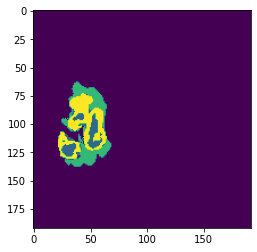

Actual 3


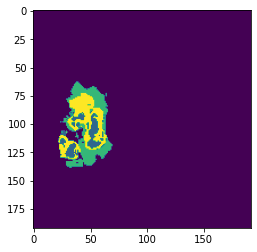

X_test 4


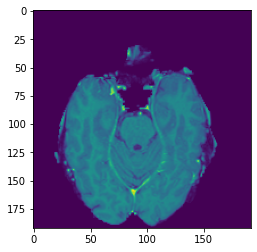

Predicted 4


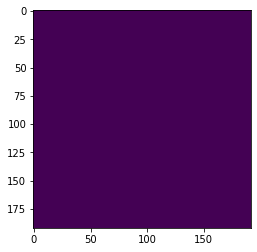

Actual 4


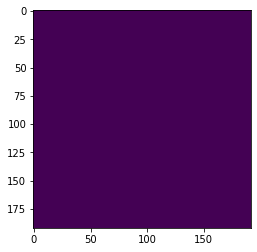

In [ ]:
for i in range(5):
  print('X_test '+ str(i))
  plt.imshow(X_test[i,:,:,2])
  plt.show()

  print('Predicted '+ str(i))
  plt.imshow(Y_pre[i,:,:,0])
  plt.show()

  print('Actual '+ str(i))
  plt.imshow(Y_test[i,:,:,0])
  plt.show()

In [ ]:
Y_test_encod = to_categorical(Y_test)

In [ ]:
train_result = model.evaluate(X_train,Y_train,verbose=0)
test_result = model.evaluate(X_test,Y_test_encod,verbose=0)
val_result = model.evaluate(X_val,Y_val,verbose=0)

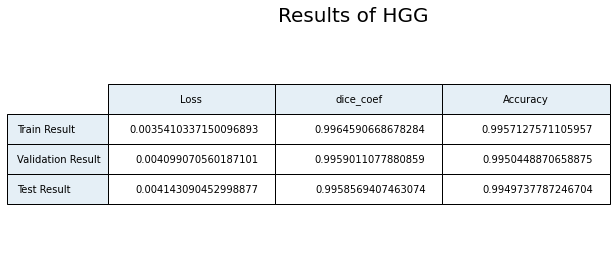

In [ ]:
cols = ['Loss', 'dice_coef', 'Accuracy']
rows = ['Train Result','Validation Result', 'Test Result']

cell_text = [train_result, val_result, test_result]

rcolors = plt.cm.BuPu(np.full(len(rows), 0.1))
ccolors = plt.cm.BuPu(np.full(len(cols), 0.1))

plt.figure(linewidth=4,
           facecolor= 'white'
          )

the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=rcolors,
                      colColours=ccolors,
                      colLabels=cols,
                      loc='center')

the_table.scale(1.5, 2.5)

plt.suptitle('Results of HGG', fontsize=20)

ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)